# cs6910 DL Assignment2 PartB

## Import

In [6]:
import warnings
warnings.filterwarnings("ignore")
from torchvision import datasets
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

## Preprocessing on the dataset

In [7]:
trainset= "/kaggle/input/inaturalist12k/Data/inaturalist_12K/train" 
testset = "/kaggle/input/inaturalist12k/Data/inaturalist_12K/val"

In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.CenterCrop((224,224)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
trainset = datasets.ImageFolder(trainset,transform_train)
testset = datasets.ImageFolder(testset,transform_test)

In [10]:
#split
n_val = int(np.floor(0.2 * len(trainset)))
n_train = len(trainset) - n_val
trainset,evalset=random_split(trainset,[n_train,n_val])
#train_ds, val_ds = random_split(trainset, [n_train, n_val])
testset,testset2=random_split(testset,[len(testset),0])

In [11]:
batch_size = 32  #you better know the importamce of batchsize especially with respect to GPU memory

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

## Accessing the GPU

In [42]:
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## First Resnet Variant

In [43]:
#resnet = models.resnet50(pretrained=True)
resnet = torchvision.models.resnet50(pretrained=True)


In [45]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
for param in resnet.parameters():
    param.requires_grad = False

In [47]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 10)

In [48]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 2048])
torch.Size([10])


In [49]:
import torch.optim as optim
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adamax(resnet.parameters(), lr=1e-4)

In [50]:
def evaluation(dataloader ,net,loss_fn ):
    total, correct = 0, 0
    loss_epoch_arr = []
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss_epoch_arr.append(loss.item())
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    
    return 100 * correct / total,sum(loss_epoch_arr)/len(loss_epoch_arr)

 epoch:- 0 train loss:- 1.9621675791740418 train acc:- 47.0 val loss:- 1.9766233364741008 val acc:- 44.22211105552776 
 epoch:- 1 train loss:- 1.730525583744049 train acc:- 55.7625 val loss:- 1.755588726391868 val acc:- 53.576788394197095 
 epoch:- 2 train loss:- 1.5767474608421326 train acc:- 59.65 val loss:- 1.5903144450414748 val acc:- 58.87943971985993 
 epoch:- 3 train loss:- 1.4582678179740907 train acc:- 61.3875 val loss:- 1.4821925844464983 val acc:- 59.62981490745373 
 epoch:- 4 train loss:- 1.3790995430946351 train acc:- 62.4 val loss:- 1.4027810721170335 val acc:- 60.88044022011005 


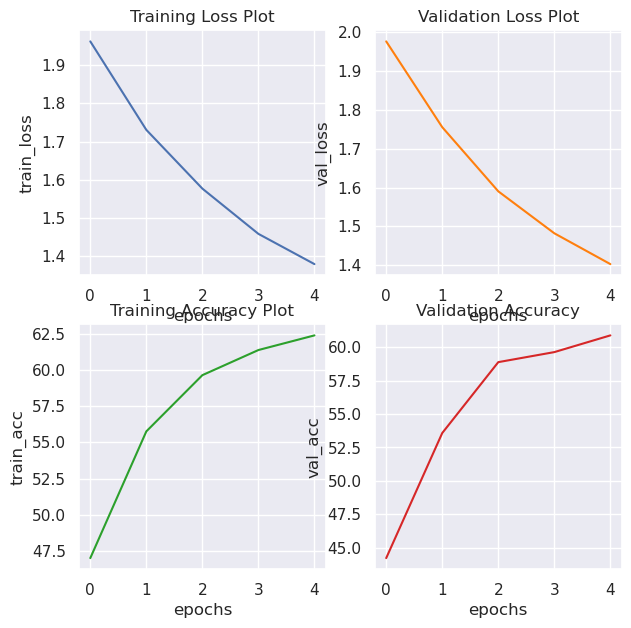

CPU times: user 28min 53s, sys: 16.4 s, total: 29min 9s
Wall time: 30min 18s


In [51]:
%%time
max_epochs = 5
train_loss_epoch_arr = []
val_loss_epoch_arr=[]
train_acc_epoch_arr=[]
val_acc_epoch_arr=[]
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_epoch_arr.append(loss.item())

    #loss_train=sum(loss_epoch_arr)/len(loss_epoch_arr)
    train_acc,train_loss=evaluation(trainloader,resnet,loss_fn)
    val_acc,val_loss=evaluation(evalloader,resnet,loss_fn)
    train_acc_epoch_arr.append(train_acc)
    val_acc_epoch_arr.append(val_acc)
    train_loss_epoch_arr.append(train_loss)
    val_loss_epoch_arr.append(val_loss)

    print(f' epoch:- {epoch} train loss:- {train_loss} train acc:- {train_acc} val loss:- {val_loss} val acc:- {val_acc} ')
    
fig, axs = plt.subplots(2, 2,figsize=(7,7))

axs[0, 0].plot(train_loss_epoch_arr)
axs[0, 0].set_title('Training Loss Plot')
axs[0,0].set(xlabel='epochs', ylabel='train_loss')

axs[0, 1].plot(val_loss_epoch_arr, 'tab:orange')
axs[0, 1].set_title('Validation Loss Plot')
axs[0,1].set(xlabel='epochs', ylabel='val_loss')


axs[1, 0].plot(train_acc_epoch_arr, 'tab:green')
axs[1, 0].set_title('Training Accuracy Plot')
axs[1,0].set(xlabel='epochs', ylabel='train_acc')

axs[1, 1].plot(val_acc_epoch_arr, 'tab:red')
axs[1, 1].set_title('Validation Accuracy')
axs[1,1].set(xlabel='epochs', ylabel='val_acc')
plt.show()


# Resnet Variant 2

In [52]:
resnet = torchvision.models.resnet50(pretrained=True)

In [53]:
# Freeze the first 10 layers of the model
for i, param in enumerate(resnet.parameters()):
    if i < 100:
        param.requires_grad = False


In [54]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 10)

In [55]:
import torch.optim as optim
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adamax(resnet.parameters(), lr=1e-4)

train loss:- 0.7539351804256439 train acc:- 76.2625 val loss:- 0.8739410061684866 val acc:- 71.2856428214107 
train loss:- 0.5902906756997108 train acc:- 80.9125 val loss:- 0.8026112526182144 val acc:- 72.58629314657328 
train loss:- 0.49908049911260605 train acc:- 84.2125 val loss:- 0.7944396332142845 val acc:- 72.73636818409204 
train loss:- 0.4414011042714119 train acc:- 85.8 val loss:- 0.7872334529483129 val acc:- 74.98749374687344 
train loss:- 0.3683241467177868 train acc:- 88.3125 val loss:- 0.7659764937938206 val acc:- 75.68784392196098 
train loss:- 0.3225818461179733 train acc:- 89.6375 val loss:- 0.8029099802176157 val acc:- 75.0375187593797 
train loss:- 0.29220609782636164 train acc:- 90.9375 val loss:- 0.8232027963986472 val acc:- 74.68734367183592 
train loss:- 0.25677552220225336 train acc:- 91.7875 val loss:- 0.8305613748610966 val acc:- 75.63781890945472 


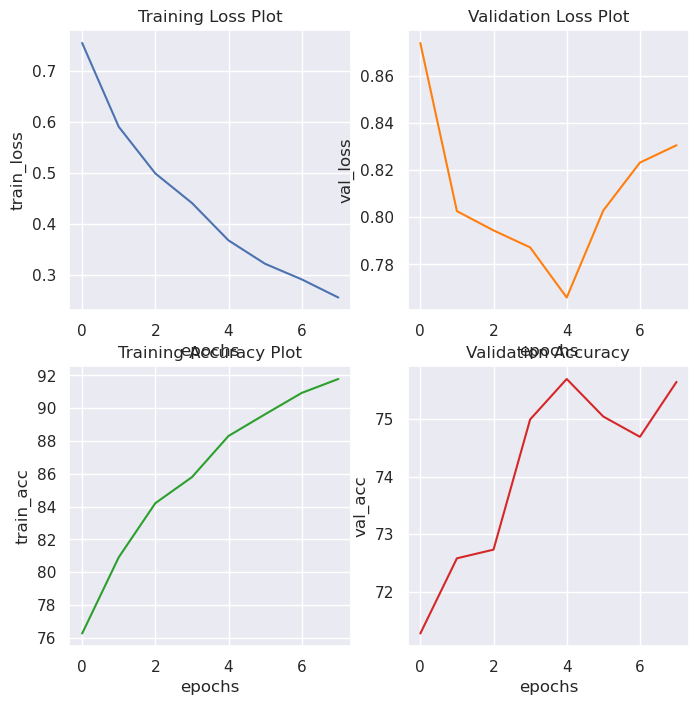

CPU times: user 47min 3s, sys: 23 s, total: 47min 26s
Wall time: 49min 1s


In [56]:
%%time
max_epochs = 8
train_loss_epoch_arr = []
val_loss_epoch_arr=[]
train_acc_epoch_arr=[]
val_acc_epoch_arr=[]
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_epoch_arr.append(loss.item())

    #loss_train=sum(loss_epoch_arr)/len(loss_epoch_arr)
    train_acc,train_loss=evaluation(trainloader,resnet,loss_fn)
    val_acc,val_loss=evaluation(evalloader,resnet,loss_fn)
    train_acc_epoch_arr.append(train_acc)
    val_acc_epoch_arr.append(val_acc)
    train_loss_epoch_arr.append(train_loss)
    val_loss_epoch_arr.append(val_loss)

    print(f'train loss:- {train_loss} train acc:- {train_acc} val loss:- {val_loss} val acc:- {val_acc} ')
    
fig, axs = plt.subplots(2, 2,figsize=(8,8))

axs[0, 0].plot(train_loss_epoch_arr)
axs[0, 0].set_title('Training Loss Plot')
axs[0,0].set(xlabel='epochs', ylabel='train_loss')

axs[0, 1].plot(val_loss_epoch_arr, 'tab:orange')
axs[0, 1].set_title('Validation Loss Plot')
axs[0,1].set(xlabel='epochs', ylabel='val_loss')


axs[1, 0].plot(train_acc_epoch_arr, 'tab:green')
axs[1, 0].set_title('Training Accuracy Plot')
axs[1,0].set(xlabel='epochs', ylabel='train_acc')

axs[1, 1].plot(val_acc_epoch_arr, 'tab:red')
axs[1, 1].set_title('Validation Accuracy')
axs[1,1].set(xlabel='epochs', ylabel='val_acc')
plt.show()
